In [24]:
import torch
import torch.nn as nn
import bisect
from typing import List, Tuple
import scipy.special as sp

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np


In [2]:
# Helper functions for spline computation
def compute_changes(x: torch.Tensor) -> torch.Tensor:
    return x[1:] - x[:-1]

def create_tridiagonal_matrix(n: int, h: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    A = torch.cat((h[:-1] / (h[:-1] + h[1:]), torch.tensor([0.0], device=h.device)))
    B = torch.full((n,), 2.0, device=h.device)
    C = torch.cat((torch.tensor([0.0], device=h.device), h[1:] / (h[:-1] + h[1:])))
    return A, B, C

def create_target(n: int, h: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    diff_quotients = 6 * ((y[2:] - y[1:-1]) / h[1:] - (y[1:-1] - y[:-2]) / h[:-1]) / (h[:-1] + h[1:])
    return torch.cat((torch.tensor([0.0], device=h.device), diff_quotients, torch.tensor([0.0], device=h.device)))

def solve_tridiagonal_system(A: torch.Tensor, B: torch.Tensor, C: torch.Tensor, D: torch.Tensor) -> torch.Tensor:
    n = B.size(0)
    c_p = torch.zeros(n, device=B.device)
    d_p = torch.zeros(n, device=B.device)
    X = torch.zeros(n, device=B.device)

    c_p[0] = C[0] / B[0]
    d_p[0] = D[0] / B[0]
    for i in range(1, n-1):
        denom = B[i] - A[i-1] * c_p[i-1]
        c_p[i] = C[i] / denom
        d_p[i] = (D[i] - A[i-1] * d_p[i-1]) / denom

    X[-1] = d_p[-1]
    for i in range(n-2, -1, -1):
        X[i] = d_p[i] - c_p[i] * X[i+1]

    return X

# Function to generate data
def generate_data(func, n_samples=1000, noise=0.1):
    x = np.random.uniform(-1, 1, n_samples)
    y = np.random.uniform(-1, 1, n_samples)
    z = func(x, y)

    # Handle functions that return tuples
    if isinstance(z, tuple):
        z = z[0]  # Take the first element of the tuple

    z += noise * np.random.randn(*z.shape)  # Adding noise
    return x, y, z


In [3]:
def compute_spline(x: torch.Tensor, y: torch.Tensor):
    if x.size(0) < 3:
        raise ValueError('Too short an array')
    if x.size(0) != y.size(0):
        raise ValueError('Array lengths are different')

    h = compute_changes(x)
    if torch.any(h <= 0):
        raise ValueError('X must be strictly increasing')

    n = x.size(0)
    A, B, C = create_tridiagonal_matrix(n, h)
    D = create_target(n, h, y)
    M = solve_tridiagonal_system(A, B, C, D)

    coefficients = torch.stack([
        (M[1:] - M[:-1]) * h**2 / 6,
        M[:-1] * h**2 / 2,
        (y[1:] - y[:-1] - (M[1:] + 2 * M[:-1]) * h**2 / 6),
        y[:-1]
    ], dim=1)

    # print("Coefficients:", coefficients)  # Debug print

    def spline(val: float) -> float:
        idx = min(bisect.bisect(x.cpu().numpy(), val) - 1, n - 2)
        z = (val - x[idx].item()) / h[idx].item()
        C = coefficients[idx]
        return (((C[0] * z + C[1]) * z + C[2]) * z + C[3]).item()

    return spline, coefficients


In [5]:
class SplineActivation(nn.Module):
    def __init__(self, num_knots=10, degree=3):
        super(SplineActivation, self).__init__()
        self.num_knots = num_knots
        self.degree = degree
        self.x = nn.Parameter(torch.linspace(-1.0, 1.0, num_knots), requires_grad=False)

        # Allow y to be updated during training
        self.y = nn.Parameter(torch.sin(self.x * 3.14159) + 0.1 * torch.randn(self.num_knots), requires_grad=True)

        # Initial computation of coefficients, just for initial debugging
        _, self.coefficients = compute_spline(self.x, self.y)
        # print("Initial Spline Activation Coefficients:", self.coefficients)  # Debug print

        self.w = nn.Parameter(torch.tensor(1.0))  # Initialize weight
        self.basis_function = nn.SiLU()  # Using SiLU (Swish) as basis function

    def forward(self, x):
        x_clipped = torch.clamp(x, -1, 1)

        # Compute the spline coefficients dynamically based on current y
        _, coefficients = compute_spline(self.x, self.y)
        # print("Spline Activation Coefficients in Forward Pass:", coefficients)  # Debug print

        # Compute the spline values in batch
        indices = torch.searchsorted(self.x, x_clipped.detach(), right=True) - 1
        indices = torch.clamp(indices, 0, self.num_knots - 2)
        idx_x = self.x[indices]
        idx_x1 = self.x[indices + 1]
        h = idx_x1 - idx_x
        z = (x_clipped - idx_x) / h
        C = coefficients[indices]

        z = z.unsqueeze(-1)
        C = C.unsqueeze(2)
        y_clipped = (((C[..., 0] * z + C[..., 1]) * z + C[..., 2]) * z + C[..., 3])
        # print(f"z shape: {z.shape}, C shape: {C.shape}, y_clipped shape: {y_clipped.shape}")  # Debug print

        return self.w * (self.basis_function(x) + y_clipped.squeeze(-1))


In [6]:
class KAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_type='spline', num_knots=10):
        super(KAN, self).__init__()
        self.phi1 = nn.Linear(input_dim, hidden_dim)
        self.psi1 = nn.Linear(input_dim, hidden_dim)
        self.phi2 = nn.Linear(hidden_dim, hidden_dim)
        self.psi2 = nn.Linear(hidden_dim, hidden_dim)
        self.phi3 = nn.Linear(hidden_dim, output_dim)
        self.psi3 = nn.Linear(hidden_dim, output_dim)
        self._he_init()

        if kernel_type == 'spline':
            self.spline1 = SplineActivation(num_knots)
            self.spline2 = SplineActivation(num_knots)
            self.spline3 = SplineActivation(num_knots)
            self.spline4 = SplineActivation(num_knots)
            self.spline5 = SplineActivation(num_knots)
            self.spline6 = SplineActivation(num_knots)

    # He initialization function
    def _he_init(self):
        for layer in [self.phi1, self.psi1, self.phi2, self.psi2, self.phi3, self.psi3]:
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        def apply_activation(act, x):
            return act(x)

        x1 = apply_activation(self.spline1, self.phi1(x))
        x2 = apply_activation(self.spline2, self.psi1(x))
        sum_x = x1 + x2
        x3 = apply_activation(self.spline3, self.phi2(sum_x))
        x4 = apply_activation(self.spline4, self.psi2(sum_x))
        sum_x2 = x3 + x4
        x5 = apply_activation(self.spline5, self.phi3(sum_x2))
        x6 = apply_activation(self.spline6, self.psi3(sum_x2))
        output = x5 + x6
        return torch.sigmoid(output)


In [11]:
def train_model(model, X_train, y_train, epochs=2000, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_list = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    print(f"Training complete! Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return model, loss_list

In [12]:
# Generate training synthetic data
X, y = make_circles(n_samples=300, noise=0.2, factor=0.25)
y = y.reshape(-1, 1)

X_train = torch.FloatTensor(X)
y_train = torch.FloatTensor(y)

# Train the models with different kernels
kernels = ['spline']
models = {}
losses = {}
input_dim, hidden_dim, output_dim = 2, 5, 1
num_knots = 3
epochs, learning_rate = 200, 0.01

for kernel in kernels:
    print(f"\nTraining KAN model with {kernel} kernel:")
    kan_model = KAN(input_dim, hidden_dim, output_dim, kernel_type=kernel, num_knots=num_knots)
    trained_model, loss_list = train_model(kan_model, X_train, y_train, epochs=epochs, learning_rate=learning_rate)
    models[kernel] = trained_model
    losses[kernel] = loss_list



Training KAN model with spline kernel:
Epoch [10/200], Loss: 0.2456
Epoch [20/200], Loss: 0.2060
Epoch [30/200], Loss: 0.1502
Epoch [40/200], Loss: 0.0932
Epoch [50/200], Loss: 0.0559
Epoch [60/200], Loss: 0.0398
Epoch [70/200], Loss: 0.0314
Epoch [80/200], Loss: 0.0268
Epoch [90/200], Loss: 0.0240
Epoch [100/200], Loss: 0.0223
Epoch [110/200], Loss: 0.0211
Epoch [120/200], Loss: 0.0202
Epoch [130/200], Loss: 0.0195
Epoch [140/200], Loss: 0.0190
Epoch [150/200], Loss: 0.0187
Epoch [160/200], Loss: 0.0182
Epoch [170/200], Loss: 0.0175
Epoch [180/200], Loss: 0.0165
Epoch [190/200], Loss: 0.0158
Epoch [200/200], Loss: 0.0153
Training complete! Epoch [200/200], Loss: 0.0153


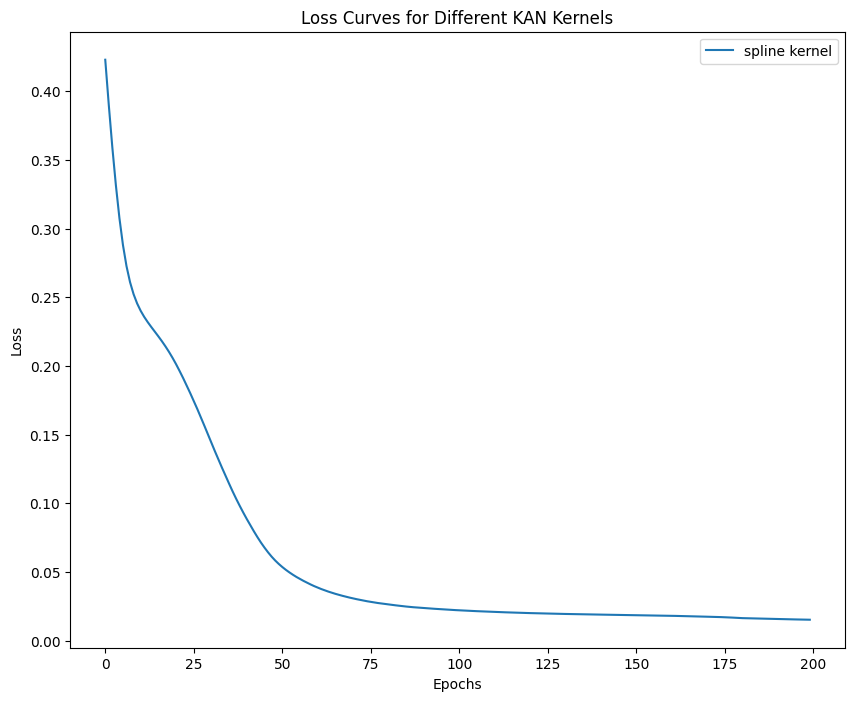

In [13]:
# Plot the loss curves
plt.figure(figsize=(10, 8))
for kernel, loss_list in losses.items():
    plt.plot(loss_list, label=f'{kernel} kernel')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves for Different KAN Kernels')
plt.show()


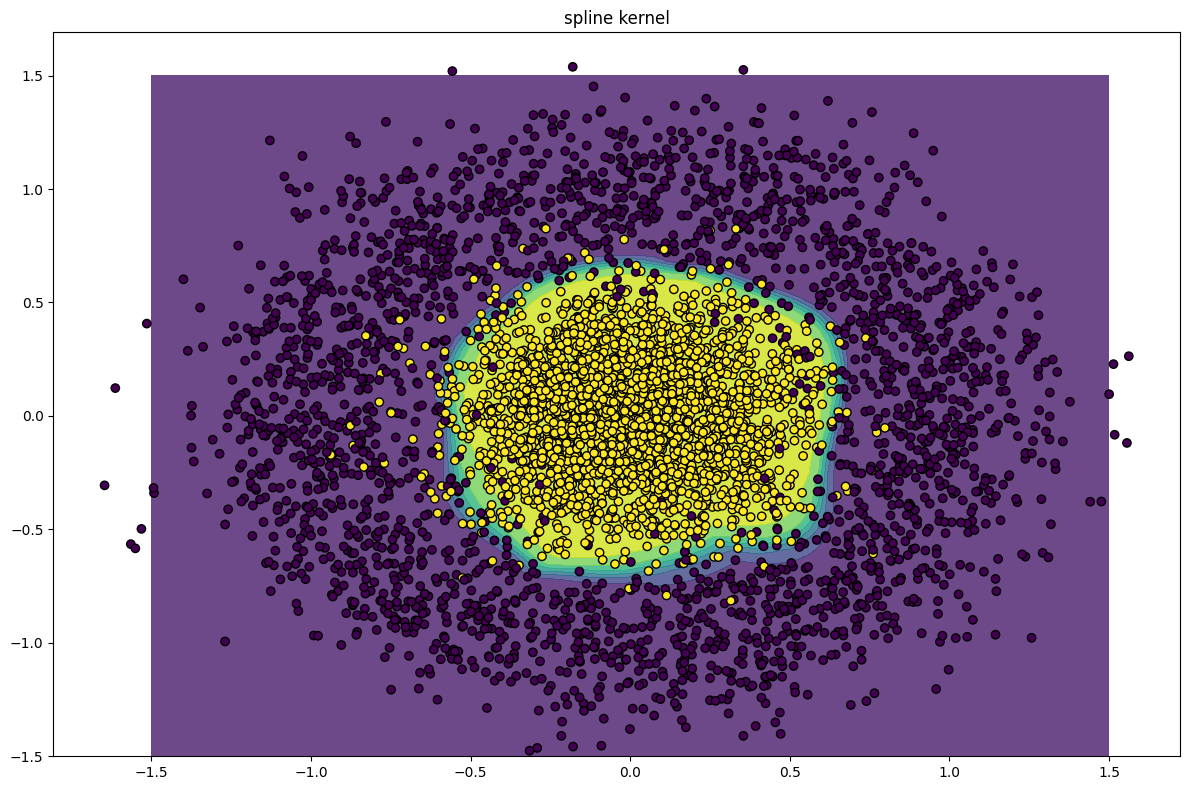

In [14]:
# Generate test synthetic data
X, y = make_circles(n_samples=5000, noise=0.2, factor=0.25)
y = y.reshape(-1, 1)

X_test = torch.FloatTensor(X)
y_test = torch.FloatTensor(y)

# Evaluate and plot decision boundaries
fig, axes = plt.subplots(1, len(kernels), figsize=(12, 8))

xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
for i, kernel in enumerate(kernels):
    model = models[kernel]
    model.eval()
    with torch.no_grad():
        Z = model(grid).reshape(xx.shape)
    ax = axes[i] if len(kernels) > 1 else axes
    ax.contourf(xx, yy, Z, alpha=0.8)
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', marker='o')
    ax.set_title(f'{kernel} kernel')

plt.tight_layout()
plt.show()


In [15]:
# Evaluate and print accuracy for each model
for kernel, model in models.items():
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == y_test).float().mean()
        print(f'Accuracy for {kernel} kernel: {accuracy:.4f}')


Accuracy for spline kernel: 0.9626


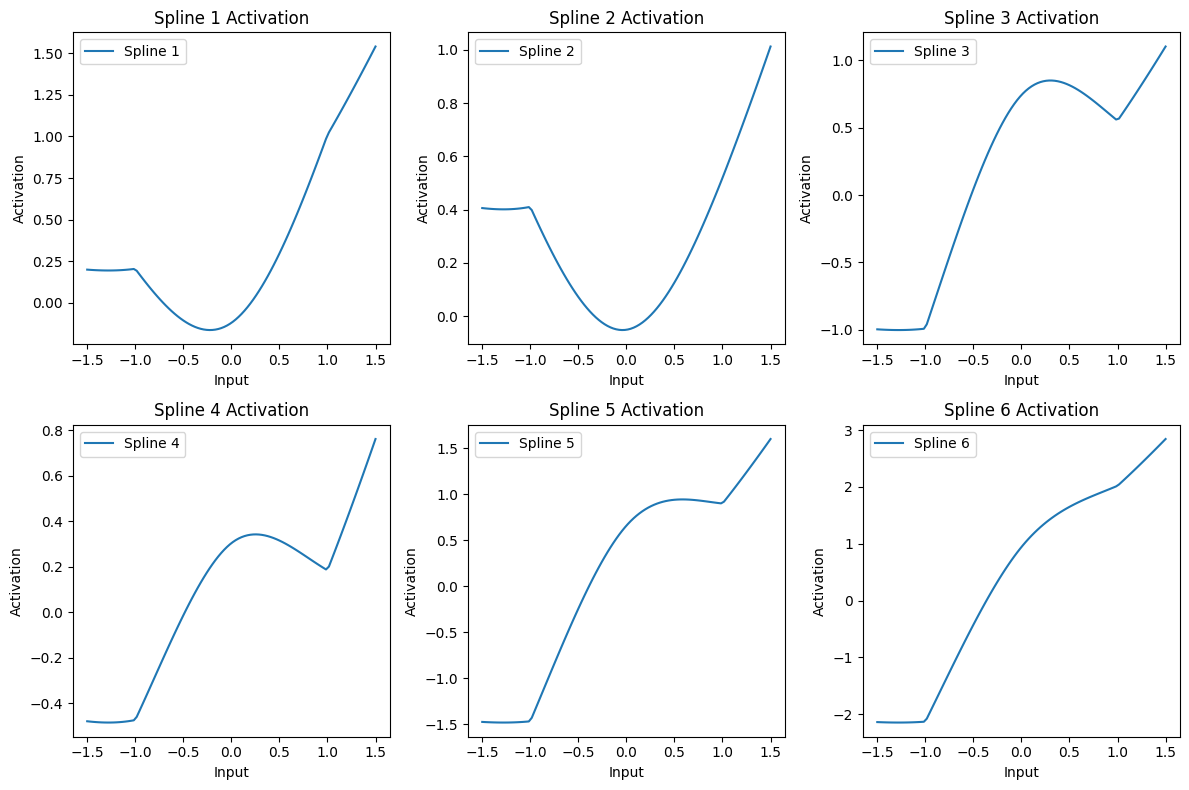

In [16]:
def plot_splines(spline_layers, num_points=100):
    # Define a range of input values
    x_vals = np.linspace(-1.5, 1.5, num_points)
    x_tensor = torch.FloatTensor(x_vals).unsqueeze(1)

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Loop through each spline layer and plot its activation
    for i, spline in enumerate(spline_layers, start=1):
        with torch.no_grad():
            spline_outputs = spline(x_tensor).numpy()
        plt.subplot(2, 3, i)  # Arrange subplots in a grid
        plt.plot(x_vals, spline_outputs, label=f'Spline {i}')
        plt.title(f'Spline {i} Activation')
        plt.xlabel('Input')
        plt.ylabel('Activation')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the spline activations for the trained model
spline_layers = [
    models['spline'].spline1,
    models['spline'].spline2,
    models['spline'].spline3,
    models['spline'].spline4,
    models['spline'].spline5,
    models['spline'].spline6,
]
plot_splines(spline_layers)

In [186]:
import scipy.special as sp

# Define the functions
def jacobian_elliptic(x, y):
    return sp.ellipj(x, y)[0]  # Return the first component

def incomplete_elliptic_integral_first(x, y):
    return sp.ellipkinc(x, y)

def incomplete_elliptic_integral_second(x, y):
    return sp.ellipeinc(x, y)

def bessel_first_kind(x, y):
    return sp.jv(x, y)

def bessel_second_kind(x, y):
    return sp.yv(x, y)

def modified_bessel_second_kind(x, y):
    return sp.kv(x, y)

def modified_bessel_first_kind(x, y):
    return sp.iv(x, y)

def legendre_function(m, x, y):
    return sp.lpmv(m, x, y)

def spherical_harmonics(m, n, x, y):
    return sp.sph_harm(m, n, x, y).real  # Return the real part

# Dictionary to store function mappings
function_dict = {
    "jacobian_elliptic": jacobian_elliptic,
    "incomplete_elliptic_integral_first": incomplete_elliptic_integral_first,
    "incomplete_elliptic_integral_second": incomplete_elliptic_integral_second,
    "bessel_first_kind": bessel_first_kind,
    "bessel_second_kind": bessel_second_kind,
    "modified_bessel_second_kind": modified_bessel_second_kind,
    "modified_bessel_first_kind": modified_bessel_first_kind,
    "legendre_function_m_0": lambda x, y: legendre_function(0, x, y),
    "legendre_function_m_1": lambda x, y: legendre_function(1, x, y),
    "legendre_function_m_2": lambda x, y: legendre_function(2, x, y),
    "spherical_harmonics_m_0_n_1": lambda x, y: spherical_harmonics(0, 1, x, y),
    "spherical_harmonics_m_1_n_1": lambda x, y: spherical_harmonics(1, 1, x, y),
    "spherical_harmonics_m_0_n_2": lambda x, y: spherical_harmonics(0, 2, x, y),
    "spherical_harmonics_m_1_n_2": lambda x, y: spherical_harmonics(1, 2, x, y),
    "spherical_harmonics_m_2_n_2": lambda x, y: spherical_harmonics(2, 2, x, y),
}

# Function to generate data
def generate_data(func, n_samples=1000, noise=0.1):
    x = np.random.uniform(-1, 1, n_samples)
    y = np.random.uniform(-1, 1, n_samples)
    z = func(x, y)

    # Handle functions that return tuples
    if isinstance(z, tuple):
        z = z[0]  # Take the first element of the tuple

    z += noise * np.random.randn(*z.shape)  # Adding noise
    return x, y, z


def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        loss = nn.MSELoss()(predictions, y_test)
    return loss.item()

def main():

    results = []

    for name, func in function_dict.items():
        print(f"Training on function: {name}")

        # Generate data
        x, y, z = generate_data(func)
        X = np.vstack((x, y)).T
        X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=42)

        # Convert to tensors
        X_train = torch.FloatTensor(X_train)
        y_train = torch.FloatTensor(y_train).unsqueeze(-1)
        X_test = torch.FloatTensor(X_test)
        y_test = torch.FloatTensor(y_test).unsqueeze(-1)

        # Train KAN model
        kan_model = KAN(input_dim=2, hidden_dim=5, output_dim=1, kernel_type='spline', num_knots=3)
        trained_kan_model, kan_loss_list = train_model(kan_model, X_train, y_train, epochs=2000, learning_rate=0.01)
        kan_rmse = np.sqrt(evaluate_model(trained_kan_model, X_test, y_test))
        print(f"{name} - KAN RMSE: {kan_rmse}")

        # Train MLP model
        mlp_model = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
        trained_mlp_model, mlp_loss_list = train_model(mlp_model, X_train, y_train, epochs=2000, learning_rate=0.01)
        mlp_rmse = np.sqrt(evaluate_model(trained_mlp_model, X_test, y_test))
        print(f"{name} - MLP RMSE: {mlp_rmse}")

        results.append((name, kan_rmse, mlp_rmse))

    # Print results
    for name, kan_rmse, mlp_rmse in results:
        print(f"{name}: KAN RMSE = {kan_rmse}, MLP RMSE = {mlp_rmse}")

if __name__ == "__main__":
    main()

Training on function: jacobian_elliptic


KeyboardInterrupt: 